In [1]:
# Basic segmentation based on otsu
# import sample data
#('/Users/zg/Mammouth/PROJECTS/Analysis/Image_Choice/MAX_PMLwt_20_MMStack_Pos0.ome.tif')
import skimage as ski

import os
filename = os.path.join(ski.data_dir, '/Users/zg/Mammouth/PROJECTS/Analysis/Image_Choice/MAX_PMLwt_20_MMStack_Pos0.ome-1-Nuc.tif')
Nucleus_PML = ski.io.imread(filename)


filename_PML = os.path.join(ski.data_dir, '/Users/zg/Mammouth/PROJECTS/Analysis/Image_Choice/MAX_PMLwt_20_MMStack_Pos0.ome-1-PML.tif')
PML = ski.io.imread(filename_PML)


In [2]:
import napari

# create a `Viewer` and `Image` layer in Napari
viewer = napari.Viewer()
viewer.add_image(Nucleus_PML, colormap='blue', name='Nucleus PML')
viewer.add_image(PML, colormap='magma', name='PML')

Assistant skips harvesting pyclesperanto as it's not installed.


<Image layer 'PML' at 0x14fd67e30>

In [3]:
#segementation using otsu
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label
from skimage.morphology import closing, square, remove_small_objects

# apply threshold on PML bodies
thresh_PML = threshold_otsu(PML)
bw = closing(PML > thresh_PML, square(5))

# remove artifacts connected to image border
cleared = remove_small_objects(clear_border(bw), 10)

# label image regions
label_image_PML = label(cleared)

# add the labels
labels_layer = viewer.add_labels(label_image_PML, name='segmentation-PML')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
# apply threshold on Nucleus
thresh_Nuc = threshold_otsu(Nucleus_PML)
bw = closing(Nucleus_PML > thresh_Nuc, square(13))

# remove artifacts connected to image border
cleared = remove_small_objects(clear_border(bw), 10)

# label image regions
label_image_Nuc = label(cleared)

# add the labels
labels_layer = viewer.add_labels(label_image_Nuc, name='segmentation-Nucleus')


In [5]:
Mask=viewer.layers[2].data

In [9]:
Result_PML=Mask*PML; #unclear if it is requird
viewer.add_image(Result_PML)

<Image layer 'Result_PML [1]' at 0x167c29520>

In [11]:
#Particle analysis on PML
from skimage import measure
import pandas as pd

#Result_PML or PML is enough ?
region_properties_PML = measure.regionprops_table(label_image_PML, Result_PML, properties=['area', 'intensity_mean'])
#pd.DataFrame(region_properties_PML);

In [12]:
#Result_PML or PML is enough ?
region_properties_Nuc = measure.regionprops_table(label_image_Nuc, Nucleus_PML, properties=['area', 'intensity_mean'])
#pd.DataFrame(region_properties_Nuc);

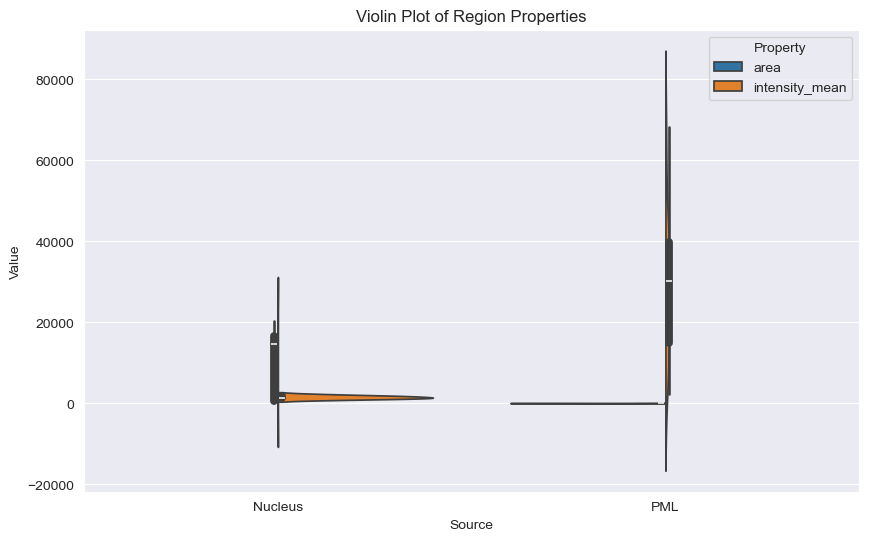

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the dictionaries to pandas DataFrames
regionNuc_df = pd.DataFrame(region_properties_Nuc)
regionPML_df = pd.DataFrame(region_properties_PML)

# Melt the DataFrames to reshape them for plotting
meltedNuc_df = regionNuc_df.melt(var_name='Property', value_name='Value')
meltedPML_df = regionPML_df.melt(var_name='Property', value_name='Value')

# Combine the melted DataFrames into a single DataFrame
combined_df = pd.concat([meltedNuc_df, meltedPML_df])

# Add a column to indicate the source of the data (Nucleus or PML)
combined_df['Source'] = ['Nucleus'] * len(meltedNuc_df) + ['PML'] * len(meltedPML_df)

# Create a violin plot with separate subplots for each property
plt.figure(figsize=(10, 6))
sns.violinplot(x='Source', y='Value', hue='Property', data=combined_df, split=True)

# Add labels and title
plt.xlabel('Source')
plt.ylabel('Value')
plt.title('Violin Plot of Region Properties')

plt.show()

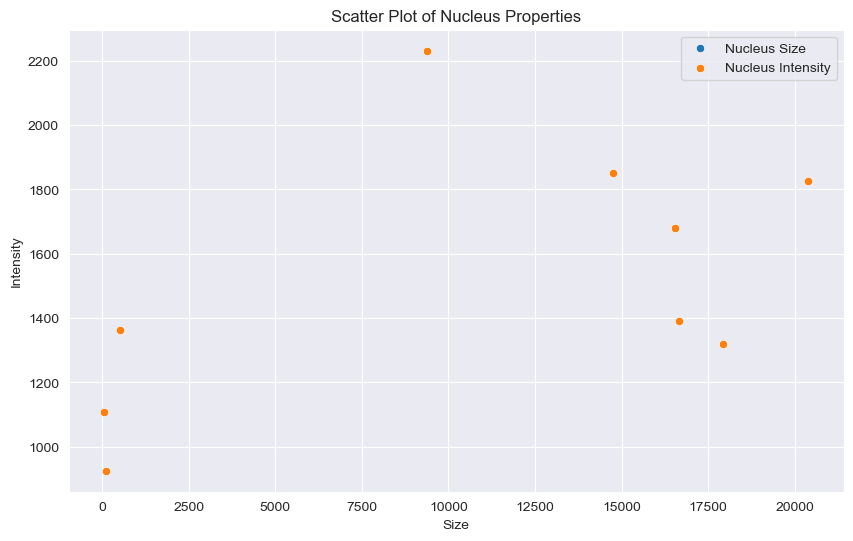

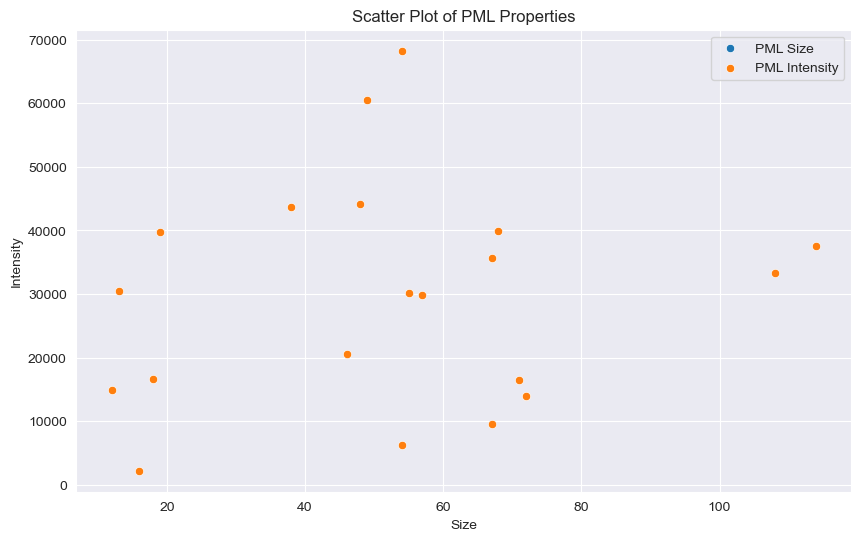

In [14]:
# Convert the dictionaries to pandas DataFrames
regionNuc_df = pd.DataFrame(region_properties_Nuc)
regionPML_df = pd.DataFrame(region_properties_PML)

# Create a scatter plot for the nucleus data
plt.figure(figsize=(10, 6))
sns.scatterplot(x='area', y='intensity_mean', data=regionNuc_df, label='Nucleus Size')
sns.scatterplot(x='area', y='intensity_mean', data=regionNuc_df, label='Nucleus Intensity')
plt.xlabel('Size')
plt.ylabel('Intensity')
plt.title('Scatter Plot of Nucleus Properties')
plt.legend()

# Create a scatter plot for the PML data
plt.figure(figsize=(10, 6))
sns.scatterplot(x='area', y='intensity_mean', data=regionPML_df, label='PML Size')
sns.scatterplot(x='area', y='intensity_mean', data=regionPML_df, label='PML Intensity')
plt.xlabel('Size')
plt.ylabel('Intensity')
plt.title('Scatter Plot of PML Properties')
plt.legend()

plt.show()


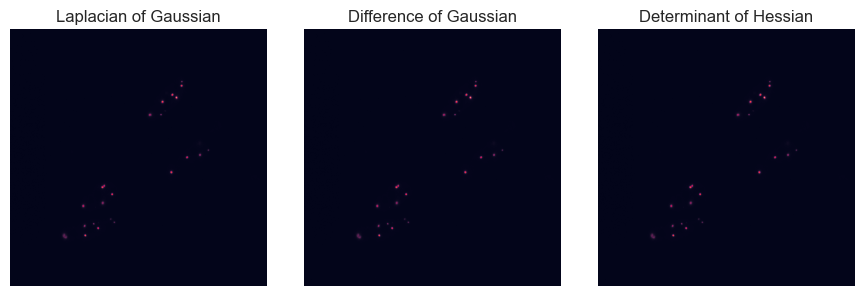

In [72]:
#Blob detection applied to PML bodies

from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt

#image = data.PMLdata()
#image_gray = rgb2gray(PMLdata)

#blobs_log = blob_log(PMLdata, max_sigma=30, num_sigma=10, threshold=0.1)

blobs_log = blob_log(PMLdata, max_sigma=30, num_sigma=10, threshold=0.5)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(PMLdata, max_sigma=30, threshold=0.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(PMLdata, max_sigma=30, threshold=0.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian', 'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(PMLdata)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()